In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from d2l import torch as d2l
import matplotlib.pyplot as plt

### 1. 获取掩码
- 在encoder和encoder-decoder的self-attention中，掩码和序列长度有关
- 在decoder_layer中的第一层self-attention中，掩码是下三角矩阵
- decoder输出掩码

#### 1.1 encoder和encoder-decoder的self-attention
假如一个句子的max_len是4，句子实际长度是2，mask矩阵为：
$$
\begin{pmatrix}
1 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
$$
长度矩阵可以换成
$$
\begin{pmatrix}
1 & 1 & 0 & 0
\end{pmatrix}
$$
这样mask矩阵计算
$$
\begin{bmatrix}
1 \\
1 \\
0 \\
0
\end{bmatrix}
\times
\begin{bmatrix}
1 & 1 & 0 & 0
\end{bmatrix}
=
\mathbf{Mask}
$$

但是由于最后计算lose的时候会计算mask，所以不需要下面的两行同样作mask，例如
$$
\begin{pmatrix}
1 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 1 & 0 & 0
\end{pmatrix}
\times
\begin{bmatrix}
v_{11} & v_{12} \\
v_{21} & v_{22} \\
v_{31} & v_{32} \\
v_{41} & v_{42} 
\end{bmatrix}
=
\begin{bmatrix}
v_{11} + v_{21} & v_{12} + v_{22} \\
v_{11} + v_{21} & v_{12} + v_{22} \\
v_{11} + v_{21} & v_{12} + v_{22} \\
v_{11} + v_{21} & v_{12} + v_{22}
\end{bmatrix}
$$
计算CrossEntropyLoss后变为
$$
\begin{bmatrix}
o_{11} & o_{12}  & o_{13} & o_{14} 
\end{bmatrix}
$$
mask之后为
$$
\begin{bmatrix}
o_{11} & o_{12} & 0 & 0 
\end{bmatrix}
$$

In [2]:
# test
# encoder/encoder-decoder
torch.manual_seed(42)
"""
输入矩阵：
    batch_size * max_seq_len * dim
    batch_size=2, max_seq_len=4, dim=8
有效长度矩阵：
    batch_size *
    batch_size=2
"""
X = torch.rand((2, 4, 8))
valid_len = torch.randint(1, 5, (2, ))
print(X, X.shape)
print(valid_len, valid_len.shape)
print()

max_len = X.shape[1]
# 获取长度矩阵
print(torch.arange(max_len)[None, :])
# 对valid_len扩容
print(valid_len.repeat_interleave(max_len)[:, None])
mask = torch.arange(max_len)[None, :] < valid_len.repeat_interleave(max_len)[:, None]
print(mask)
print()

# test
Q, K, V = X, X, X
score = torch.bmm(Q, K.permute(0, 2, 1)).reshape(-1, max_len)
print(score, score.shape)

print(score.masked_fill_(~mask, -1e6))
F.softmax(score, -1)

tensor([[[0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936],
         [0.9408, 0.1332, 0.9346, 0.5936, 0.8694, 0.5677, 0.7411, 0.4294],
         [0.8854, 0.5739, 0.2666, 0.6274, 0.2696, 0.4414, 0.2969, 0.8317],
         [0.1053, 0.2695, 0.3588, 0.1994, 0.5472, 0.0062, 0.9516, 0.0753]],

        [[0.8860, 0.5832, 0.3376, 0.8090, 0.5779, 0.9040, 0.5547, 0.3423],
         [0.6343, 0.3644, 0.7104, 0.9464, 0.7890, 0.2814, 0.7886, 0.5895],
         [0.7539, 0.1952, 0.0050, 0.3068, 0.1165, 0.9103, 0.6440, 0.7071],
         [0.6581, 0.4913, 0.8913, 0.1447, 0.5315, 0.1587, 0.6542, 0.3278]]]) torch.Size([2, 4, 8])
tensor([3, 2]) torch.Size([2])

tensor([[0, 1, 2, 3]])
tensor([[3],
        [3],
        [3],
        [3],
        [2],
        [2],
        [2],
        [2]])
tensor([[ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True, False, False],
        [ True,  True, F

tensor([[0.5236, 0.2350, 0.2413, 0.0000],
        [0.2534, 0.5926, 0.1541, 0.0000],
        [0.4537, 0.2687, 0.2775, 0.0000],
        [0.2740, 0.5073, 0.2187, 0.0000],
        [0.5842, 0.4158, 0.0000, 0.0000],
        [0.3829, 0.6171, 0.0000, 0.0000],
        [0.5999, 0.4001, 0.0000, 0.0000],
        [0.4191, 0.5809, 0.0000, 0.0000]])

#### 1.2 decoder_layer中的第一层self-attention
例如序列长度为3, 最大长度为4，下三角矩阵:
$$
\begin{pmatrix}
1 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 \\
1 & 1 & 1 & 1
\end{pmatrix}
$$
因为序列长度为3，实际的mask为:
$$
\begin{pmatrix}
1 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
$$
但这里其实没有必要，最后计算loss的时候会有一个loss掩码消除，后续会说明

In [3]:
# test
torch.manual_seed(46)
"""
输入矩阵：
    batch_size * max_seq_len * dim
    batch_size=2, max_seq_len=4, dim=8
有效长度矩阵：
    batch_size *
    batch_size=2
"""
X = torch.rand((2, 4, 8))
valid_len = torch.randint(1, 5, (2, ))
print(X, X.shape)
print(valid_len, valid_len.shape)
print()

batch_size = X.shape[0]
max_len = X.shape[1]
dec_valid_len = torch.arange(1, max_len + 1).repeat(batch_size)
print(dec_valid_len)
mask = torch.arange(max_len)[None, :] < dec_valid_len[:, None]
print(mask)
print()

# test
Q, K, V = X, X, X
score = torch.bmm(Q, K.permute(0, 2, 1)).reshape(-1, score.shape[-1])
# print(score, score.shape)

print(score.masked_fill_(~mask, -1e6))
F.softmax(score, -1)

tensor([[[0.6611, 0.0600, 0.5174, 0.1596, 0.7550, 0.8390, 0.0674, 0.4631],
         [0.1477, 0.3597, 0.9328, 0.0170, 0.9736, 0.4108, 0.8620, 0.8799],
         [0.6569, 0.8152, 0.4810, 0.7388, 0.0312, 0.7049, 0.7364, 0.1079],
         [0.1455, 0.2633, 0.9035, 0.6618, 0.9728, 0.9471, 0.8585, 0.9694]],

        [[0.6430, 0.4919, 0.3397, 0.7519, 0.0770, 0.1563, 0.7086, 0.5063],
         [0.2131, 0.3311, 0.7764, 0.2493, 0.1992, 0.9874, 0.2860, 0.0898],
         [0.1783, 0.0602, 0.5747, 0.9875, 0.1572, 0.1534, 0.7301, 0.7916],
         [0.6019, 0.7746, 0.4704, 0.7769, 0.8160, 0.4427, 0.1632, 0.6080]]]) torch.Size([2, 4, 8])
tensor([3, 4]) torch.Size([2])

tensor([1, 2, 3, 4, 1, 2, 3, 4])
tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True],
        [ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])

ten

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.1816, 0.8184, 0.0000, 0.0000],
        [0.1588, 0.2223, 0.6189, 0.0000],
        [0.0728, 0.2366, 0.0691, 0.6214],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.3196, 0.6804, 0.0000, 0.0000],
        [0.3217, 0.1412, 0.5370, 0.0000],
        [0.1909, 0.1251, 0.1764, 0.5076]])

#### decoder输出掩码

In [4]:
# test
torch.manual_seed(46)
"""
输入矩阵：
    batch_size * max_seq_len 
    batch_size=2, max_seq_len=4, dim=8
有效长度矩阵：
    batch_size *
    batch_size=2
"""
y_hat = torch.rand((2, 4, 8))
y = torch.randint(0, 4, (2, 4))
out_valid_len = torch.randint(1, 5, (2, ))
print(y_hat, y_hat.shape)
print(y, y.shape)
print(out_valid_len, out_valid_len.shape)
print()

loss = nn.CrossEntropyLoss(reduction="none")
l = loss(y_hat.permute(0, 2, 1), y)
print(l)
print()

max_len = y_hat.shape[1]
mask = torch.arange(max_len)[None, :] < out_valid_len[:, None]
print(mask)
mask_one = torch.ones_like(y)
mask_one[~mask] = 0
l = l * mask_one
print(l, l.mean())

tensor([[[0.6611, 0.0600, 0.5174, 0.1596, 0.7550, 0.8390, 0.0674, 0.4631],
         [0.1477, 0.3597, 0.9328, 0.0170, 0.9736, 0.4108, 0.8620, 0.8799],
         [0.6569, 0.8152, 0.4810, 0.7388, 0.0312, 0.7049, 0.7364, 0.1079],
         [0.1455, 0.2633, 0.9035, 0.6618, 0.9728, 0.9471, 0.8585, 0.9694]],

        [[0.6430, 0.4919, 0.3397, 0.7519, 0.0770, 0.1563, 0.7086, 0.5063],
         [0.2131, 0.3311, 0.7764, 0.2493, 0.1992, 0.9874, 0.2860, 0.0898],
         [0.1783, 0.0602, 0.5747, 0.9875, 0.1572, 0.1534, 0.7301, 0.7916],
         [0.6019, 0.7746, 0.4704, 0.7769, 0.8160, 0.4427, 0.1632, 0.6080]]]) torch.Size([2, 4, 8])
tensor([[2, 3, 1, 0],
        [2, 3, 2, 1]]) torch.Size([2, 4])
tensor([2, 4]) torch.Size([2])

tensor([[2.0437, 2.6967, 1.8350, 2.6926],
        [2.2255, 2.2697, 2.0158, 1.9066]])

tensor([[ True,  True, False, False],
        [ True,  True,  True,  True]])
tensor([[2.0437, 2.6967, 0.0000, 0.0000],
        [2.2255, 2.2697, 2.0158, 1.9066]]) tensor(1.6447)


#### 1.4 上述掩码整合并测试

In [5]:
def sequence_mask(score_mat : torch.Tensor, valid_len : torch.Tensor) -> torch.Tensor:
    assert score_mat.dim() == 3, print(f"score_mat dim is {score_mat.dim()}")
    assert valid_len.dim() == 1, print(f"valid_len dim is {valid_len.dim()}")
    max_len = score_mat.shape[1]
    mask = torch.arange(max_len)[None, :] < valid_len[:, None]
    return mask

# enc_mask
enc_score = torch.randn((2, 4, 8))
enc_valid_len = torch.tensor([3, 2])
enc_valid_len = enc_valid_len.repeat_interleave(enc_score.shape[1])

enc_mask = sequence_mask(enc_score, enc_valid_len)
print(enc_mask)

# dec_mask
dec_score = torch.randn((2, 4, 8))
batch_size = dec_score.shape[0]
max_len = dec_score.shape[1]
dec_valid_len = torch.tensor([1, 4])
dec_valid_len = torch.arange(1, 1 + max_len).repeat(batch_size)
dec_mask = sequence_mask(dec_score, dec_valid_len)
print(dec_mask)

# lose mask
loss = torch.randn((2, 4))
dec_valid_len = torch.tensor([3, 2])
loss_mask = sequence_mask(loss.unsqueeze(2), dec_valid_len)
print(loss_mask)

tensor([[ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True, False, False],
        [ True,  True, False, False],
        [ True,  True, False, False],
        [ True,  True, False, False]])
tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True],
        [ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])
tensor([[ True,  True,  True, False],
        [ True,  True, False, False]])


#### 1.5 mask_softmax

In [6]:
def mask_softmax(score : torch.Tensor, valid_len : torch.Tensor) -> torch.Tensor:
    score_mask = sequence_mask(score, valid_len)
    score = score.reshape(-1, score.shape[-1])
    score = score.masked_fill(~score_mask, -1e6)
#     print(score)
    return F.softmax(score, -1)

# enc_mask
enc_score = torch.randn((2, 4, 4))
enc_valid_len = torch.tensor([3, 2])
enc_valid_len = enc_valid_len.repeat_interleave(enc_score.shape[1])

enc_attention = mask_softmax(enc_score, enc_valid_len)
print(enc_attention)

tensor([[0.5119, 0.3282, 0.1598, 0.0000],
        [0.1228, 0.3177, 0.5594, 0.0000],
        [0.2407, 0.3907, 0.3685, 0.0000],
        [0.4797, 0.1503, 0.3700, 0.0000],
        [0.4430, 0.5570, 0.0000, 0.0000],
        [0.5710, 0.4290, 0.0000, 0.0000],
        [0.4452, 0.5548, 0.0000, 0.0000],
        [0.4024, 0.5976, 0.0000, 0.0000]])


### 2.位置编码
$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right) \\
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

In [7]:
"""
    我们拿一个batch的matrix举例
    假设矩阵的batch_size=2, max_len=8，dim=4
""" 
torch.manual_seed(42)
X = torch.rand(2, 8, 4)
batch_size = X.shape[0]
max_len = X.shape[1]
dim = X.shape[2]
print(X)
pos_mat = torch.arange(max_len)
dim_mat = torch.arange(0, dim, 2) / dim
dim_mat = torch.pow(1/10000, dim_mat)
pos_embeding_mat = pos_mat[:, None] * dim_mat[None, :]
print(pos_embeding_mat, pos_embeding_mat.shape)

position_embeding = torch.zeros_like(X)
position_embeding[:, :, 0::2] = torch.sin(pos_embeding_mat)
position_embeding[:, :, 1::2] = torch.cos(pos_embeding_mat)
position_embeding

tensor([[[0.8823, 0.9150, 0.3829, 0.9593],
         [0.3904, 0.6009, 0.2566, 0.7936],
         [0.9408, 0.1332, 0.9346, 0.5936],
         [0.8694, 0.5677, 0.7411, 0.4294],
         [0.8854, 0.5739, 0.2666, 0.6274],
         [0.2696, 0.4414, 0.2969, 0.8317],
         [0.1053, 0.2695, 0.3588, 0.1994],
         [0.5472, 0.0062, 0.9516, 0.0753]],

        [[0.8860, 0.5832, 0.3376, 0.8090],
         [0.5779, 0.9040, 0.5547, 0.3423],
         [0.6343, 0.3644, 0.7104, 0.9464],
         [0.7890, 0.2814, 0.7886, 0.5895],
         [0.7539, 0.1952, 0.0050, 0.3068],
         [0.1165, 0.9103, 0.6440, 0.7071],
         [0.6581, 0.4913, 0.8913, 0.1447],
         [0.5315, 0.1587, 0.6542, 0.3278]]])
tensor([[0.0000, 0.0000],
        [1.0000, 0.0100],
        [2.0000, 0.0200],
        [3.0000, 0.0300],
        [4.0000, 0.0400],
        [5.0000, 0.0500],
        [6.0000, 0.0600],
        [7.0000, 0.0700]]) torch.Size([8, 2])


tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.9093, -0.4161,  0.0200,  0.9998],
         [ 0.1411, -0.9900,  0.0300,  0.9996],
         [-0.7568, -0.6536,  0.0400,  0.9992],
         [-0.9589,  0.2837,  0.0500,  0.9988],
         [-0.2794,  0.9602,  0.0600,  0.9982],
         [ 0.6570,  0.7539,  0.0699,  0.9976]],

        [[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.9093, -0.4161,  0.0200,  0.9998],
         [ 0.1411, -0.9900,  0.0300,  0.9996],
         [-0.7568, -0.6536,  0.0400,  0.9992],
         [-0.9589,  0.2837,  0.0500,  0.9988],
         [-0.2794,  0.9602,  0.0600,  0.9982],
         [ 0.6570,  0.7539,  0.0699,  0.9976]]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


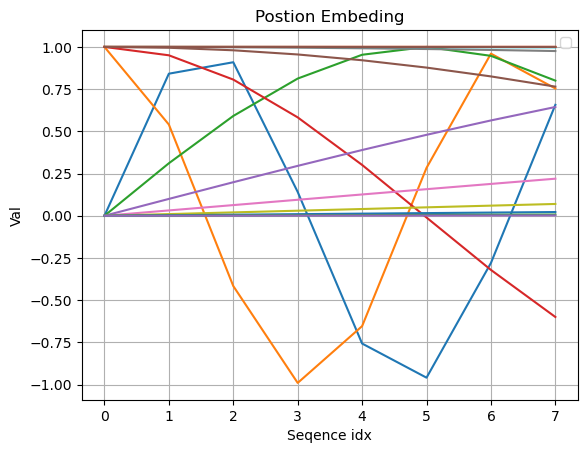

In [8]:
"""
封装成函数
"""
def postion_embeding(batch_size, max_len, dim) -> torch.Tensor:
    position_embeding = torch.zeros((batch_size, max_len, dim))
    
    position_mat = torch.arange(max_len)[:, None] / torch.pow(10000, 
                                                              torch.arange(0, dim, 2) / dim)[None, :]
    
    position_embeding[:, :, 0::2] = torch.sin(position_mat)
    position_embeding[:, :, 1::2] = torch.cos(position_mat)
    
    return position_embeding

def show_position(position_embeding : torch.Tensor):
    assert position_embeding.dim() == 2, print(f"enc_input dim is {position_embeding.dim()}")
    
    num_rows, num_cols = position_embeding.shape

    for col in range(num_cols):
        plt.plot(range(num_rows), position_embeding[:, col])

    plt.title("Postion Embeding") 
    plt.xlabel("Seqence idx")  
    plt.ylabel("Val")  
    plt.xticks(range(num_rows))  
    plt.legend()  
    plt.grid(True)  
    plt.show() 

enc_input = torch.rand(2, 8, 16)
position_embeding = postion_embeding(enc_input.shape[0], enc_input.shape[1], enc_input.shape[2])
show_position(position_embeding[0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


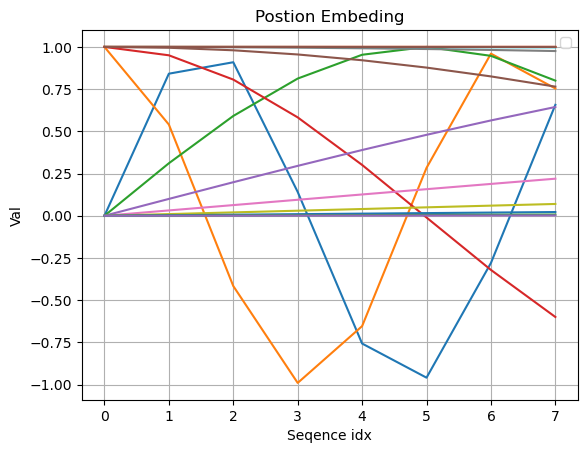

torch.Size([2, 8, 16])

In [9]:
"""
类函数
"""
class PositionEmbeding(nn.Module):
    def __init__(self, batch_size, max_len, dims, dropout):
        super(PositionEmbeding, self).__init__()
        self.pe = postion_embeding(batch_size, max_len, dims)
        self.drop = nn.Dropout(dropout)
        
    def forward(self, X):
        assert X.shape == self.pe.shape, print(f"X shape is not equal to pe {X.shape} vs {self.pe.shape}!")
        return self.drop(X + self.pe.to(X.device))
    
    def show_position(self):
        show_position(self.pe[0])

enc_input = torch.rand(2, 8, 16)
position_embeding = PositionEmbeding(enc_input.shape[0], enc_input.shape[1], enc_input.shape[2], 0)
position_embeding.show_position()
position_embeding(enc_input).shape

### 3. MutilHeadAttention
#### 3.1 DotProductAttention

In [10]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super(DotProductAttention, self).__init__()
        self.drop = nn.Dropout(dropout)
        
    def forward(self, querys : torch.Tensor, keys : torch.Tensor, values : torch.Tensor, valid_lens : torch.Tensor):
        assert querys.dim() == keys.dim() == values.dim() == 3
        self.attention_weights = torch.bmm(querys, keys.transpose(1, 2)) / math.sqrt(querys.shape[-1])
        # [batch_size, max_len, max_len] --> [batch_size * max_len, max_len]
        self.attention_weights = mask_softmax(self.attention_weights, valid_lens)
        self.attention_weights = self.attention_weights.reshape(querys.shape[0], querys.shape[1], querys.shape[1])
#         print(self.attention_weights)
        return torch.bmm(self.drop(self.attention_weights), values)
    
dpatten = DotProductAttention(0.2)
querys = torch.rand((2, 4, 8))
keys = torch.rand((2, 4, 8))
values = torch.rand((2, 4, 8))

max_len = querys.shape[1]
valid_lens = torch.tensor([2, 3])
enc_valid_lens = valid_lens.repeat_interleave(max_len)
dpatten(querys, keys, values, enc_valid_lens).shape

torch.Size([2, 4, 8])

#### 3.2 MutilHeadAttention

In [11]:
class MutilHeadAttention(nn.Module):
    def __init__(self, query_size, key_size, val_size, 
                 num_heads, num_hiddens, 
                 dropout, bias = False):
        super(MutilHeadAttention, self).__init__()
        assert num_hiddens % num_heads == 0, print(f"num_hiddens:{num_hiddens} or num_heads:{num_heads} set error!")
        
        self.num_hiddens = num_hiddens
        self.num_heads = num_heads
        self.num_hiddens_one_head = num_hiddens // num_heads
        self.W_Q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_K = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_V = nn.Linear(val_size, num_hiddens, bias=bias)
        self.W_out = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        
        self.attention = DotProductAttention(dropout)
        
    def forward(self, Q : torch.Tensor, K : torch.Tensor, V : torch.Tensor, 
                valid_lens : torch.Tensor):
        assert Q.shape[-1] == K.shape[-1] == V.shape[-1] == self.num_hiddens, print("num_hiddens is not equal to Q, K, V dims")
        assert Q.shape[0] == K.shape[0] == V.shape[0], print("batch size is not equal")
        assert valid_lens.shape[0] == Q.shape[0] * Q.shape[1] * self.num_heads, print(
            f"batch_size:{Q.shape[0]}, max_len:{Q.shape[1]}, num_heads:{self.num_heads}, lens of valid_lens:{valid_lens.shape[0]}")
        
        querys = self._transpose_qkv(self.W_Q(Q))
        keys = self._transpose_qkv(self.W_K(K))
        value = self._transpose_qkv(self.W_V(V))
        
        out = self._transpose_out(self.attention(querys, keys, value, valid_lens))
        return self.W_out(out)
        
    
    def _transpose_qkv(self, X : torch.Tensor) -> torch.Tensor:
        '''
        batch_size * max_len * num_hiddens --> batch_size * num_head * max_len * num_hiddens/num_head
        --> [ batch_size * num_head, max_len, num_hiddens/num_head ]
        '''
        shape = X.shape
        X = X.reshape(shape[0], shape[1], self.num_heads, self.num_hiddens_one_head)
        return X.permute(0, 2, 1, 3).reshape(-1, shape[1], self.num_hiddens_one_head)
    
    def _transpose_out(self, X : torch.Tensor) -> torch.Tensor:
        '''
        [ batch_size * num_head, max_len, num_hiddens/num_head ] 
    --> [ batch_size,  num_head, max_len, num_hiddens/num_head ] 
    --> [ batch_size, max_len, num_head, num_hiddens/num_head ] 
    --> [ batch_size, max_len, num_hiddens ]
        '''
        shape = X.shape
        X = X.reshape(shape[0] // self.num_heads, self.num_heads, shape[1], self.num_hiddens_one_head)
        return X.permute(0, 2, 1, 3).reshape(-1, shape[1], self.num_heads * self.num_hiddens_one_head)
    
attention = MutilHeadAttention(8, 8, 8, 2, 8, 0.2)
querys = torch.rand((2, 4, 8))
keys = torch.rand((2, 4, 8))
values = torch.rand((2, 4, 8))

# encoder
max_len = querys.shape[1]
valid_lens = torch.tensor([2, 3])
enc_valid_lens = valid_lens.repeat_interleave(max_len).repeat_interleave(2)
attention(querys, keys, values, enc_valid_lens).shape

torch.Size([2, 4, 8])

In [12]:
X = torch.arange(8).reshape(2, 4)
print(X)
Y = X.reshape(2, 2, 2)
print(Y)
Z = Y.permute(1, 0, 2)
print(Z)

tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]])
tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])
tensor([[[0, 1],
         [4, 5]],

        [[2, 3],
         [6, 7]]])


### 4.FFN / ADD&Norm

In [13]:
class PositionWiseFFN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, bias = False):
        super(PositionWiseFFN, self).__init__()
        self.dense1 = nn.Linear(in_features, hidden_features, bias=bias)
        self.ac = nn.ReLU()
        self.dense2 = nn.Linear(hidden_features, out_features, bias=bias)

    def forward(self, X : torch.Tensor) -> torch.Tensor:
        return self.dense2(self.ac(self.dense1(X)))

X = torch.rand((2, 4, 8))
ffn = PositionWiseFFN(8, 16, 8)
print(ffn(X).shape)

class AddNorm(nn.Module):
    def __init__(self, in_features, dropout, bias = False):
        super(AddNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(in_features)
        self.drop = nn.Dropout(dropout)

    def forward(self, X1 : torch.Tensor, X2 : torch.Tensor) -> torch.Tensor:
        return self.layer_norm(X1 + self.drop(X2))

an = AddNorm(2, 0.2)
an(torch.Tensor([[1, 1]]), torch.Tensor([[1, 2]]))

torch.Size([2, 4, 8])


tensor([[-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>)

### 5.Transformer Encoder
#### 5.1 EncoderLayer

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features,
                       dropout, index, bias = False):
        super(EncoderLayer, self).__init__()
        assert num_hiddens == in_features
        self.num_heads = num_heads
        self.index = index
        self.attention1 = MutilHeadAttention(query_size, key_size, val_size, num_heads, num_hiddens, dropout)
        self.add_norm1 = AddNorm(num_hiddens, dropout)
        self.ffn1 = PositionWiseFFN(in_features, hidden_features, out_features)
        self.add_norm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X : torch.Tensor, valid_lens : torch.Tensor) -> torch.Tensor:

        max_len = X.shape[1]
        if valid_lens is not None:
            enc_valid_lens = valid_lens.repeat_interleave(max_len).repeat_interleave(self.num_heads)

        Y1 = self.attention1(X, X, X, enc_valid_lens)
        Y2 = self.add_norm1(X, Y1)
        return self.add_norm2(Y2, self.ffn1(Y2))

X = torch.rand((2, 4, 8))
enc_valid = torch.Tensor([2, 3])
query_size, key_size, val_size, num_heads, num_hiddens = 8, 8, 8, 2, 8
in_features, hidden_features, out_features = 8, 16, 8
dropout = 0.2
enc_layer = EncoderLayer(query_size, key_size, val_size, num_heads, num_hiddens, in_features, hidden_features, out_features, dropout, 0)
out = enc_layer(X, enc_valid)
print(out.shape)
enc_layer.attention1.attention.attention_weights

torch.Size([2, 4, 8])


tensor([[[0.4938, 0.5062, 0.0000, 0.0000],
         [0.4793, 0.5207, 0.0000, 0.0000],
         [0.4796, 0.5204, 0.0000, 0.0000],
         [0.4928, 0.5072, 0.0000, 0.0000]],

        [[0.4728, 0.5272, 0.0000, 0.0000],
         [0.4774, 0.5226, 0.0000, 0.0000],
         [0.4735, 0.5265, 0.0000, 0.0000],
         [0.4817, 0.5183, 0.0000, 0.0000]],

        [[0.3448, 0.3308, 0.3243, 0.0000],
         [0.3372, 0.3367, 0.3261, 0.0000],
         [0.3339, 0.3384, 0.3277, 0.0000],
         [0.3263, 0.3397, 0.3340, 0.0000]],

        [[0.3309, 0.3351, 0.3340, 0.0000],
         [0.3305, 0.3377, 0.3319, 0.0000],
         [0.3308, 0.3384, 0.3308, 0.0000],
         [0.3284, 0.3343, 0.3374, 0.0000]]], grad_fn=<ViewBackward0>)

#### 5.2 Transformer Encoder

In [15]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features, num_encoder_layers,
                       dropout, bias = False):
        super(TransformerEncoder, self).__init__()
        assert num_encoder_layers > 0
        self.embeding = nn.Embedding(vocab_size, num_hiddens)
        self.layers = nn.Sequential()
        self.num_hiddens = num_hiddens
        for i in range(num_encoder_layers):
            self.layers.add_module(f"encoder_layer_{i}", 
                      EncoderLayer(query_size, key_size, val_size, num_heads, num_hiddens, 
                                   in_features, hidden_features, out_features, dropout, i))
    def forward(self, X : torch.Tensor, valid_lens : torch.Tensor) -> (torch.Tensor, torch.Tensor):
        assert X.dim() == 2
        X_emb = self.embeding(X)
        # print(X_emb.shape)
        position_embeding = postion_embeding(X_emb.shape[0], X_emb.shape[1], X_emb.shape[2])
        X_emb = X_emb * math.sqrt(self.num_hiddens) + position_embeding
        for layer in self.layers:
            X_emb = layer(X_emb, valid_lens)

        return X_emb, valid_lens

X = torch.randint(0, 16, (2, 4))
enc_valid = torch.Tensor([2, 3])
vocab_size = 16
query_size, key_size, val_size, num_heads, num_hiddens = 8, 8, 8, 2, 8
in_features, hidden_features, out_features = 8, 16, 8
dropout, num_encoder_layers = 0.2, 2
encoder = TransformerEncoder(vocab_size, query_size, key_size, val_size, num_heads, num_hiddens, 
                         in_features, hidden_features, out_features, num_encoder_layers, dropout)
out = encoder(X, enc_valid)
print(out[0].shape)
print(out[1])
print(encoder.layers[0].attention1.attention.attention_weights)
# enc_layer.attention1.attention.attention_weights

torch.Size([2, 4, 8])
tensor([2., 3.])
tensor([[[0.0013, 0.9987, 0.0000, 0.0000],
         [0.9969, 0.0031, 0.0000, 0.0000],
         [0.6259, 0.3741, 0.0000, 0.0000],
         [0.0562, 0.9438, 0.0000, 0.0000]],

        [[0.0968, 0.9032, 0.0000, 0.0000],
         [0.3869, 0.6131, 0.0000, 0.0000],
         [0.4481, 0.5519, 0.0000, 0.0000],
         [0.5088, 0.4912, 0.0000, 0.0000]],

        [[0.4266, 0.2394, 0.3340, 0.0000],
         [0.1777, 0.0653, 0.7571, 0.0000],
         [0.0764, 0.7179, 0.2057, 0.0000],
         [0.0597, 0.6669, 0.2734, 0.0000]],

        [[0.1935, 0.3210, 0.4855, 0.0000],
         [0.2055, 0.0974, 0.6971, 0.0000],
         [0.0403, 0.0566, 0.9031, 0.0000],
         [0.5786, 0.1427, 0.2787, 0.0000]]], grad_fn=<ViewBackward0>)


### 6.Transformer Decoder
#### 6.1 DecoderLayer

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features,
                       dropout, index, bias = False):
        super(DecoderLayer, self).__init__()
        assert num_hiddens == in_features
        self.index = index
        self.num_heads = num_heads
        self.self_attention = MutilHeadAttention(query_size, key_size, val_size, num_heads, num_hiddens, dropout)
        self.add_norm1 = AddNorm(num_hiddens, dropout)
        
        self.encoder_decoder_attention = MutilHeadAttention(query_size, key_size, val_size, num_heads, num_hiddens, dropout)
        self.add_norm2 = AddNorm(num_hiddens, dropout)
        
        self.ffn = PositionWiseFFN(in_features, hidden_features, out_features)
        self.add_norm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X : torch.Tensor, encoder_states : (torch.Tensor, torch.Tensor)) -> torch.Tensor:
        batch_size = X.shape[0]
        max_len = X.shape[1]
        encoder_output, encoder_valid_lens = encoder_states[0], encoder_states[1]
        # print(X.shape, encoder_output.shape, encoder_valid_lens.shape)
        if valid_lens is not None:
            dec_valid_lens = torch.arange(1, 1 + max_len).repeat(batch_size).repeat(self.num_heads)
            # print(dec_valid_lens.shape[0])
        Y1 = self.add_norm1(X, self.self_attention(X, X, X, dec_valid_lens))

        enc_valid_lens = encoder_valid_lens.repeat_interleave(max_len).repeat_interleave(self.num_heads)
        Y2 = self.add_norm2(Y1, self.encoder_decoder_attention(Y1, encoder_output, encoder_output, enc_valid_lens))
        
        return self.add_norm3(Y2, self.ffn(Y2))

dec_input = torch.rand((2, 4, 8))
enc_output = torch.rand((2, 4, 8))
enc_valid_lens = torch.tensor([2, 3])

query_size, key_size, val_size, num_heads, num_hiddens = 8, 8, 8, 2, 8
in_features, hidden_features, out_features = 8, 16, 8
dropout = 0.2
decoderlayer = DecoderLayer(query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features,
                       dropout, 0)
print(decoderlayer(dec_input, (enc_output, enc_valid_lens)).shape)
print(decoderlayer.self_attention.attention.attention_weights)
print(decoderlayer.encoder_decoder_attention.attention.attention_weights)

torch.Size([2, 4, 8])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4975, 0.5025, 0.0000, 0.0000],
         [0.3330, 0.3297, 0.3373, 0.0000],
         [0.2448, 0.2449, 0.2423, 0.2680]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4862, 0.5138, 0.0000, 0.0000],
         [0.3357, 0.3405, 0.3238, 0.0000],
         [0.2558, 0.2603, 0.2292, 0.2546]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5566, 0.4434, 0.0000, 0.0000],
         [0.3531, 0.3109, 0.3360, 0.0000],
         [0.2776, 0.2110, 0.2490, 0.2624]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4904, 0.5096, 0.0000, 0.0000],
         [0.3320, 0.3332, 0.3348, 0.0000],
         [0.2435, 0.2670, 0.2348, 0.2547]]], grad_fn=<ViewBackward0>)
tensor([[[0.4914, 0.5086, 0.0000, 0.0000],
         [0.5003, 0.4997, 0.0000, 0.0000],
         [0.5135, 0.4865, 0.0000, 0.0000],
         [0.4991, 0.5009, 0.0000, 0.0000]],

        [[0.4892, 0.5108, 0.0000, 0.0000],
         [0.5337, 0.4663, 0.0000, 0.0000

#### 6.2 Transformer Decoder

In [17]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features, num_decoder_layers,
                       dropout, bias = False):
        super(TransformerDecoder, self).__init__()
        assert num_decoder_layers > 0
        self.embeding = nn.Embedding(vocab_size, num_hiddens)
        self.layers = nn.Sequential()
        self.num_hiddens = num_hiddens
        for i in range(num_decoder_layers):
            self.layers.add_module(f"decoder_layer_{i}", 
                      DecoderLayer(query_size, key_size, val_size, num_heads, num_hiddens, 
                                   in_features, hidden_features, out_features, dropout, i))

        self.dense = nn.Linear(num_hiddens, vocab_size)
            
    def init_states(self, encoder_states):
        self.encoder_states = encoder_states
        
    def forward(self, X : torch.Tensor) -> torch.Tensor:
        assert X.dim() == 2
        X = self.embeding(X)
        # print(X_emb.shape)
        position_embeding = postion_embeding(X.shape[0], X.shape[1], X.shape[2])
        X = X * math.sqrt(self.num_hiddens) + position_embeding
        for layer in self.layers:
            X = layer(X, self.encoder_states)

        return self.dense(X)

dec_input = torch.randint(0, 16, (2, 4))
enc_out = torch.rand((2, 4, 8))
enc_valid = torch.Tensor([3, 1])
vocab_size = 16
query_size, key_size, val_size, num_heads, num_hiddens = 8, 8, 8, 2, 8
in_features, hidden_features, out_features = 8, 16, 8
dropout, num_encoder_layers = 0.2, 2
decoder = TransformerDecoder(vocab_size, query_size, key_size, val_size, num_heads, num_hiddens, 
                         in_features, hidden_features, out_features, num_encoder_layers, dropout)
decoder.init_states((enc_out, enc_valid))
out = decoder(X)
print(out.shape)
print(decoder.layers[0].self_attention.attention.attention_weights)
print(decoder.layers[0].encoder_decoder_attention.attention.attention_weights)

torch.Size([2, 4, 16])
tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [9.8543e-01, 1.4571e-02, 0.0000e+00, 0.0000e+00],
         [1.0575e-01, 8.9420e-01, 5.3564e-05, 0.0000e+00],
         [3.1763e-03, 1.3731e-02, 4.8809e-01, 4.9500e-01]],

        [[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [9.9997e-01, 3.1431e-05, 0.0000e+00, 0.0000e+00],
         [6.1189e-02, 5.7161e-01, 3.6721e-01, 0.0000e+00],
         [7.1930e-01, 2.7634e-03, 2.5407e-01, 2.3874e-02]],

        [[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [9.9956e-01, 4.4106e-04, 0.0000e+00, 0.0000e+00],
         [3.4005e-01, 2.4580e-03, 6.5749e-01, 0.0000e+00],
         [5.5383e-01, 4.8379e-03, 4.0631e-01, 3.5021e-02]],

        [[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.8075e-01, 7.1925e-01, 0.0000e+00, 0.0000e+00],
         [4.8059e-01, 3.3400e-01, 1.8541e-01, 0.0000e+00],
         [1.0457e-03, 1.9729e-02, 2.9182e-01, 6.8740e-01]]],
       grad_fn=<ViewBackw

### 7.Transformer

In [18]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features, num_decoder_layers,
                       dropout, bias = False):
        super(Transformer, self).__init__()
        self.encoder = TransformerEncoder(vocab_size, query_size, key_size, val_size, num_heads, num_hiddens, 
                         in_features, hidden_features, out_features, num_encoder_layers, dropout)
        self.decoder = TransformerDecoder(vocab_size, query_size, key_size, val_size, num_heads, num_hiddens, 
                         in_features, hidden_features, out_features, num_encoder_layers, dropout)

    def forward(self, X, Y, enc_valid_lens):
        enc_output, enc_valid_lens = self.encoder(X, enc_valid_lens)
        self.decoder.init_states((enc_output, enc_valid_lens))
        return self.decoder(Y)

vocab_size = 16
query_size, key_size, val_size, num_heads, num_hiddens = 8, 8, 8, 2, 8
in_features, hidden_features, out_features = 8, 16, 8
dropout, num_encoder_layers = 0.2, 2
model = Transformer(vocab_size, query_size, key_size, val_size, num_heads, num_hiddens, 
                    in_features, hidden_features, out_features, num_encoder_layers, dropout)
X = torch.randint(0, 16, (2, 4))
enc_valid_lens = torch.Tensor([2, 3])
Y = torch.randint(0, 16, (2, 4))

y_hat = model(X, Y, enc_valid_lens)
print(y_hat.shape)
print(model.encoder.layers[0].attention1.attention.attention_weights)
print(model.decoder.layers[0].self_attention.attention.attention_weights)
print(model.decoder.layers[0].encoder_decoder_attention.attention.attention_weights)

torch.Size([2, 4, 16])
tensor([[[2.5718e-01, 7.4282e-01, 0.0000e+00, 0.0000e+00],
         [1.5775e-02, 9.8422e-01, 0.0000e+00, 0.0000e+00],
         [9.8972e-01, 1.0280e-02, 0.0000e+00, 0.0000e+00],
         [9.9961e-01, 3.9204e-04, 0.0000e+00, 0.0000e+00]],

        [[6.4403e-01, 3.5597e-01, 0.0000e+00, 0.0000e+00],
         [1.1316e-01, 8.8684e-01, 0.0000e+00, 0.0000e+00],
         [9.5780e-01, 4.2196e-02, 0.0000e+00, 0.0000e+00],
         [9.9730e-01, 2.7006e-03, 0.0000e+00, 0.0000e+00]],

        [[9.7367e-01, 1.4704e-03, 2.4856e-02, 0.0000e+00],
         [9.1625e-01, 4.1015e-03, 7.9653e-02, 0.0000e+00],
         [9.9813e-01, 5.2210e-06, 1.8605e-03, 0.0000e+00],
         [5.2960e-03, 9.2198e-01, 7.2725e-02, 0.0000e+00]],

        [[9.5191e-02, 6.2811e-01, 2.7670e-01, 0.0000e+00],
         [3.7840e-02, 8.7630e-01, 8.5861e-02, 0.0000e+00],
         [5.4655e-01, 2.6407e-01, 1.8938e-01, 0.0000e+00],
         [9.9531e-01, 2.2123e-04, 4.4671e-03, 0.0000e+00]]],
       grad_fn=<ViewBackw